### single collection of E

In [15]:
from shapely.geometry import Point, Polygon,MultiLineString,MultiPolygon,GeometryCollection,LineString
from shapely.affinity import scale
import trimesh
import numpy as np

def scale_geometry(geometry, point, scale_value):
    return scale(geometry, xfact=scale_value, yfact=scale_value, origin=point)

def delete_alternate_element(geometry):
    return [geometry[i] for i in range(0, len(geometry), 2)]

def single_e_colletion(start_x, start_y, start_z, radius, height, layer_height, no_circle, no_circle_row):
    overall_scaled_coords = []
    for i in range(no_circle):
        mesh = trimesh.creation.cylinder(radius=radius, height=height, center=(start_x, start_y, start_z))
        min_bound = int(mesh.bounds[0][2]) 
        max_bound = int(mesh.bounds[1][2])
        z_slices = np.arange(min_bound, max_bound + layer_height, layer_height)
        coord_dict = {}
        for z in z_slices:
            scale_coords = []
            section = mesh.section(plane_origin=[0, 0, z], plane_normal=[0, 0, 1])
            if section is None:
                continue
            for entity in section.entities:
                coords_2D = [(round(section.vertices[i][0] + start_x, 3),round(section.vertices[i][1] + start_y, 3)) for i in entity.points]
                filtered_circle = delete_alternate_element(coords_2D)
                filtered_polygon = Polygon(filtered_circle)
                scaled_poly = scale_geometry(filtered_polygon, (start_x, start_y), 1.05)
                scale_coords.append(list(scaled_poly.exterior.coords))
            coord_dict[round(z+radius,2)] = scale_coords[0]
        overall_scaled_coords.append(coord_dict)
        start_x += 3 * radius
        if (i + 1) % no_circle_row == 0:
            start_x -= no_circle_row * 3 * radius
            start_y += 3 * radius
    return overall_scaled_coords

coords = single_e_colletion(20,20,0,5,10,0.2,5,3)

### Group Of E-collections

In [16]:
def maximum(geometry):
    all_points = [pt for d in geometry for coords in d.values() for pt in coords]
    max_x = max(pt[0] for pt in all_points)
    max_y = max(pt[1] for pt in all_points)
    return max_x, max_y

def minimum(geometry):
    all_points =[pt for d in geometry for coords in d.values() for pt in coords]
    min_x = min(pt[0] for pt in all_points)
    min_y = min(pt[1] for pt in all_points)
    return min_x, min_y

def e_collection(start_x,start_y,start_z,radius,height,layer_height,no_circle,no_circle_row,gap,no_of_e,no_of_e_row):
    all_scaled_docs=[]
    for i in range(1,no_of_e+1):
        scaled_docs=single_e_colletion(start_x,start_y,start_z,radius,height,layer_height,no_circle,no_circle_row)
        all_scaled_docs.extend(scaled_docs)
        max_x,max_y=maximum(scaled_docs)
        start_x=max_x+gap
        if i%(no_of_e_row)==0:
            start_x=start_x-((gap*no_of_e_row)+((no_circle_row-1)*no_of_e_row*3*radius)+(no_of_e_row*radius))
            start_y=max_y+gap
    return all_scaled_docs

many_coords=e_collection(20,20,0,5,10,0.2,6,3,20,3,2)

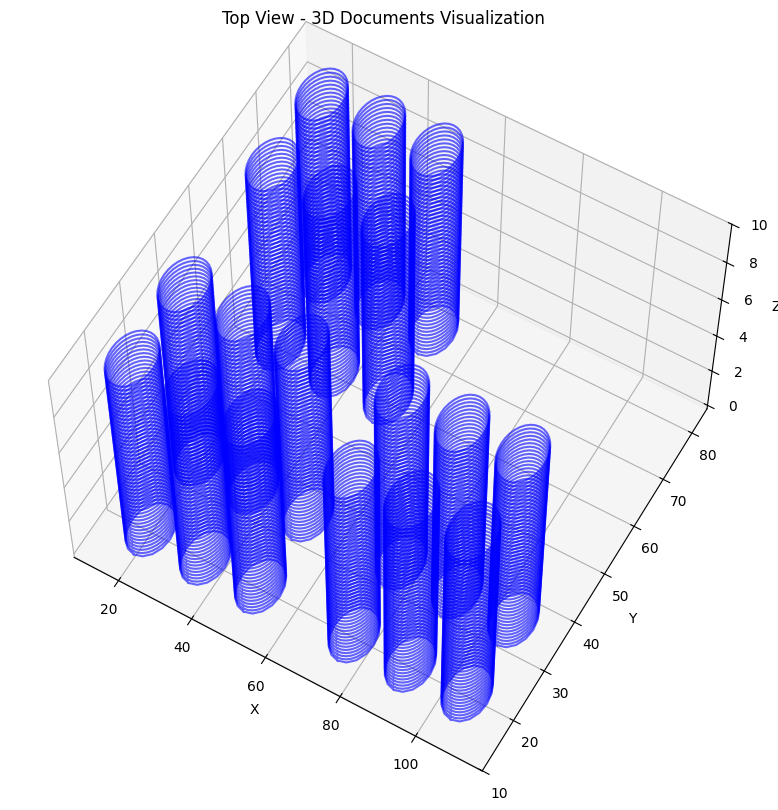

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_coords(data):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    for document in data:
        for z, points in document.items():
            xs, ys = zip(*points)
            zs = [z] * len(xs)
            xs += (xs[0],)
            ys += (ys[0],)
            zs += (zs[0],)
            ax.plot(xs, ys, zs, color='b', alpha=0.6)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Top View - 3D Documents Visualization')
    ax.view_init(elev=60, azim=-60) 
    plt.tight_layout()
    plt.show()

plot_3d_coords(many_coords)


### D-collection

In [18]:
def d_collection(start_x,start_y,start_z,radius,height,layer_height,no_circle,no_circle_row,gap,no_of_e,no_of_e_row,no_of_d,no_of_d_row,d_gap):
    scaled_values=[]
    scaled_polygon_coords=[]
    for i in range(1,no_of_d+1):
        scaled_docs=e_collection(start_x,start_y,start_z,radius,height,layer_height,no_circle,no_circle_row,gap,no_of_e,no_of_e_row)
        max_x,max_y=maximum(scaled_docs)
        start_x=max_x+d_gap
        scaled_values.append(scaled_docs)
        if i%(no_of_d_row)==0:
            start_x=start_x-(no_of_e_row*no_of_d_row*radius)-(no_of_d_row*d_gap)-(no_of_d_row*(no_of_e_row-1)*gap)-((no_circle_row-1)*no_of_e_row*no_of_d_row*radius*3)
            start_y=max_y+d_gap
        polygon_list=[]
        for shell in scaled_docs:
            for z,coords in shell.items():
                polygon_list.append(Polygon(coords))
        multi_poly=MultiPolygon(polygon_list)
        scaled_polygon_coords.append(multi_poly)
    return scaled_polygon_coords,scaled_values

multi_many_coords,multi_many_values=d_collection(20,20,0,2,4,0.1,5,3,10,3,2,2,2,10)

In [19]:
from collections import defaultdict

def combining_individual_e_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap):
    scaled_coords, scaled_value = d_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e,no_of_e_row, no_of_d, no_of_d_row, d_gap)
    
    group_list = []
    for cluster in scaled_value:
        for doc in range(0, (no_circle * no_of_e), no_circle):
            group_list.append(cluster[doc:doc + no_circle])
    merged_group_list = []
    for sublist in group_list:
        merged_dict = {}
        for d in sublist:
            for k, v in d.items():
                if k not in merged_dict:
                    merged_dict[k]=[]
                merged_dict[k]+=v
        merged_group_list.append(dict(merged_dict))

    all_coord=[]
    for i, inner_dict in enumerate(merged_group_list):
        each_e=[]
        for z, xy_list in inner_dict.items():
            for x, y in xy_list:
                each_e.append((round(x,2),round(y,2),float(z)))
        all_coord.append(each_e)
    return all_coord

collection_of_e=combining_individual_e_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 10, 3, 2, 2, 2, 10)

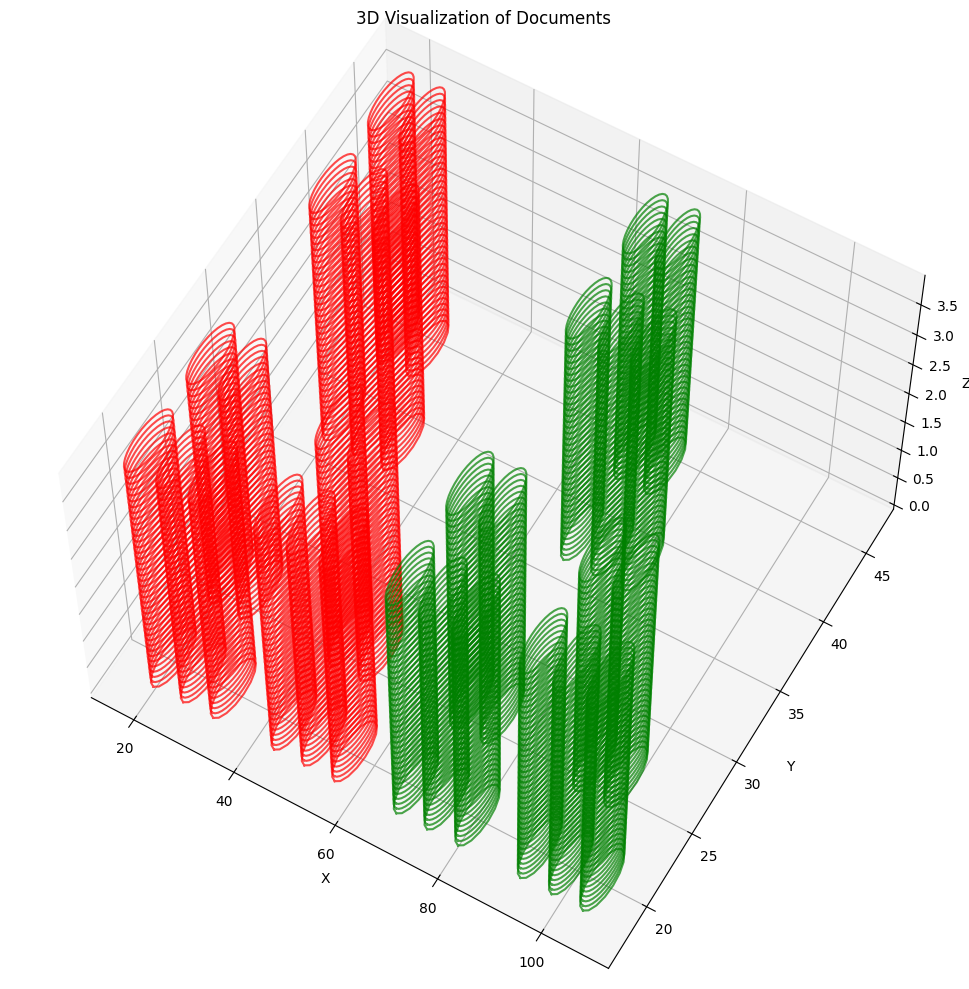

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_documents(document_clusters):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')

    colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'cyan', 'magenta']

    for cluster_idx, cluster in enumerate(document_clusters):
        color = colors[cluster_idx % len(colors)]
        for doc in cluster:
            for z_val, coords in doc.items():
                xs = [pt[0] for pt in coords]
                ys = [pt[1] for pt in coords]
                zs = [z_val] * len(coords)
                xs.append(xs[0])
                ys.append(ys[0])
                zs.append(z_val)
                ax.plot(xs, ys, zs, color=color, alpha=0.7)

    ax.set_title("3D Visualization of Documents")
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.view_init(elev=60, azim=-60) 
    plt.tight_layout()
    plt.show()

plot_3d_documents(multi_many_values)

## c collections

In [21]:

def c_document(start_x,start_y,start_z,radius,height,layer_height,no_circle,no_circle_row,gap,no_of_e,no_of_e_row,no_of_d,no_of_d_row,d_gap,no_of_c,no_of_c_row,c_gap): 
    scaled_b_document=[]
    for i in range(1,no_of_c+1):
        coord,value=d_collection(start_x,start_y,start_z,radius,height,layer_height,no_circle,no_circle_row,gap,no_of_e,no_of_e_row,no_of_d,no_of_d_row,d_gap)
        scaled_b_document.append(value)
        for j in value:
            max_x,max_y=maximum(j)
            start_x=max_x+c_gap     
            if i%(no_of_c_row)==0:
                start_x=start_x-(no_of_e_row*no_of_d_row*radius)-(no_of_d_row*d_gap)-(no_of_d_row*(no_of_e_row-1)*gap)-((no_circle_row-1)*no_of_e_row*no_of_d_row*radius*3)
                start_y=max_y+c_gap
    return scaled_b_document

documents = c_document(20,20,0,2,4,0.1,5,3,10,3,2,3,2,40,2,2,200)

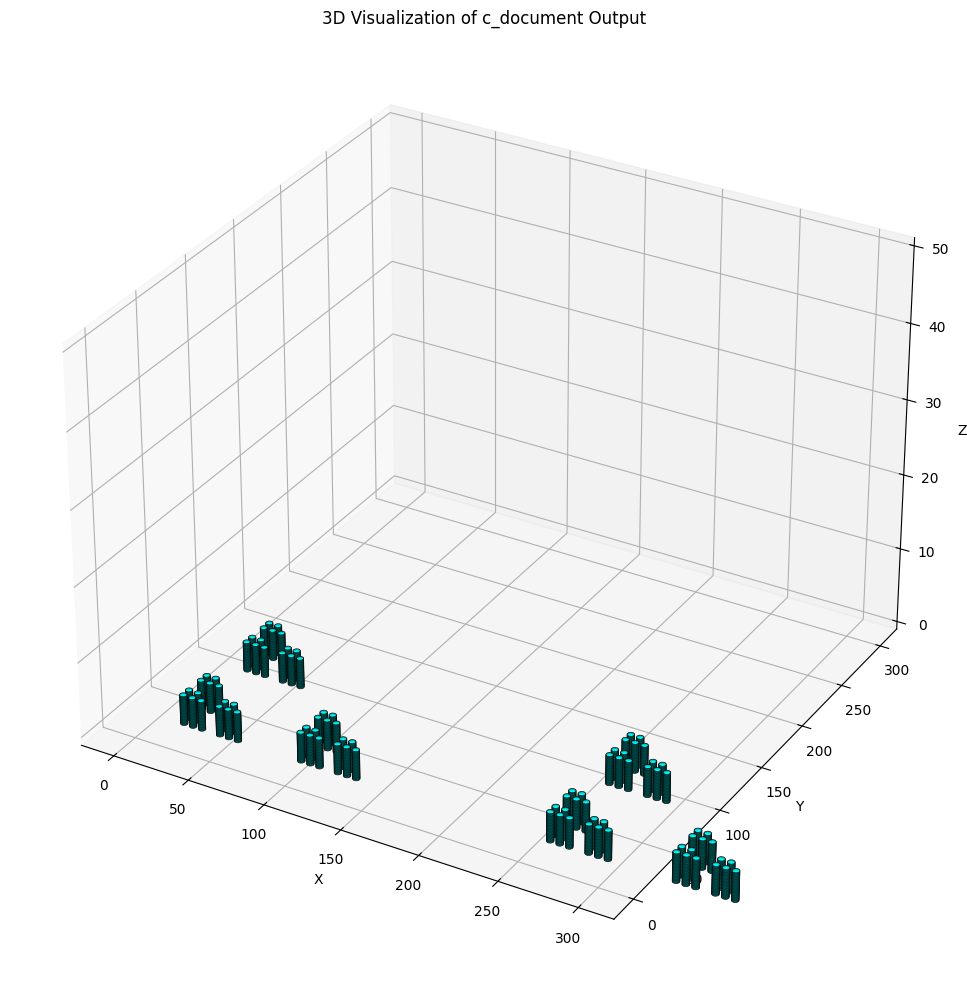

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import Polygon

def plot_3d_polygons(documents):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    for block in documents:
        for multi_doc in block:
            for cylinder in multi_doc:
                if isinstance(cylinder, dict):
                    for z, coords in cylinder.items():
                        polygon = Polygon(coords)
                        if not polygon.is_empty:
                            poly_3d = [[(x, y, z) for x, y in polygon.exterior.coords]]
                            ax.add_collection3d(Poly3DCollection(poly_3d, facecolors='cyan', linewidths=0.5, edgecolors='black', alpha=0.6))

    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.set_title("3D Visualization of c_document Output")
    ax.auto_scale_xyz([0, 300], [0, 300], [0, 50])
    plt.tight_layout()
    plt.show()
documents = c_document(20,20,0,2,4,0.1,5,3,10,3,2,3,2,40,2,2,200)
plot_3d_polygons(documents)


## Creating Square Grid on group of E-Collections

In [23]:
def create_square_grid(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d,no_of_d_row, d_gap, p_value):
    coord,value=d_collection(start_x,start_y,start_z,radius,height,layer_height,no_circle,no_circle_row,gap,no_of_e,no_of_e_row,no_of_d,no_of_d_row,d_gap)
    all_polygons = []
    all_linestring = []
    all_geometry = []

    for cluster in value:
        for doc in range(0,(no_circle*no_of_e),no_circle):
            group=cluster[doc:doc+no_circle]
            merged_polygon={}
            for i in group:
                for key,value in i.items():
                    if key not in merged_polygon:
                        merged_polygon[key]=[]
                    merged_polygon[key].extend([value])
            all_point=[coords for coords in merged_polygon.values()]
            z_layers=np.arange(0,height,layer_height)
            for Height in z_layers:
                layer_index = int(Height / layer_height)
                cylinder_linestring = Polygon([(x, y, Height) for coords in all_point[layer_index] for x, y in coords])
                all_polygons.append(MultiPolygon([cylinder_linestring]))
                    
                

            merged_linestring={}
            for i in group:
                for key,value in i.items():
                    if key not in merged_linestring:
                        merged_linestring[key]=[]
                    merged_linestring[key].extend(value)
            all_point=[coords for coords in merged_linestring.values()]
            min_x= [min(x for x, y in sublist) for sublist in all_point]
            min_y= [min(y for x, y in sublist) for sublist in all_point]
            max_x= [max(x for x, y in sublist) for sublist in all_point]
            max_y= [max(y for x, y in sublist) for sublist in all_point]
            for i in range(len(min_x)):
                min_x_i = min_x[i]
                max_x_i = max_x[i]
                min_y_i = min_y[i]
                max_y_i = max_y[i]
                z = i * layer_height
                vertical_lines = [LineString([(x, min_y_i, z), (x, max_y_i, z)]) for x in range(int(min_x_i), int(max_x_i) + 1, p_value)]
                horizontal_lines = [LineString([(min_x_i, y, z), (max_x_i, y, z)]) for y in range(int(min_y_i), int(max_y_i) + 1, p_value)]    
                multilines=MultiLineString(vertical_lines + horizontal_lines)
                all_linestring.append(multilines)
                all_geometry.append(multilines)
    return GeometryCollection(all_geometry), all_linestring, all_polygons

geom,lineString,polygon = create_square_grid(20,20,0,2,4,0.1,5,3,10,3,2,2,2,10,4)

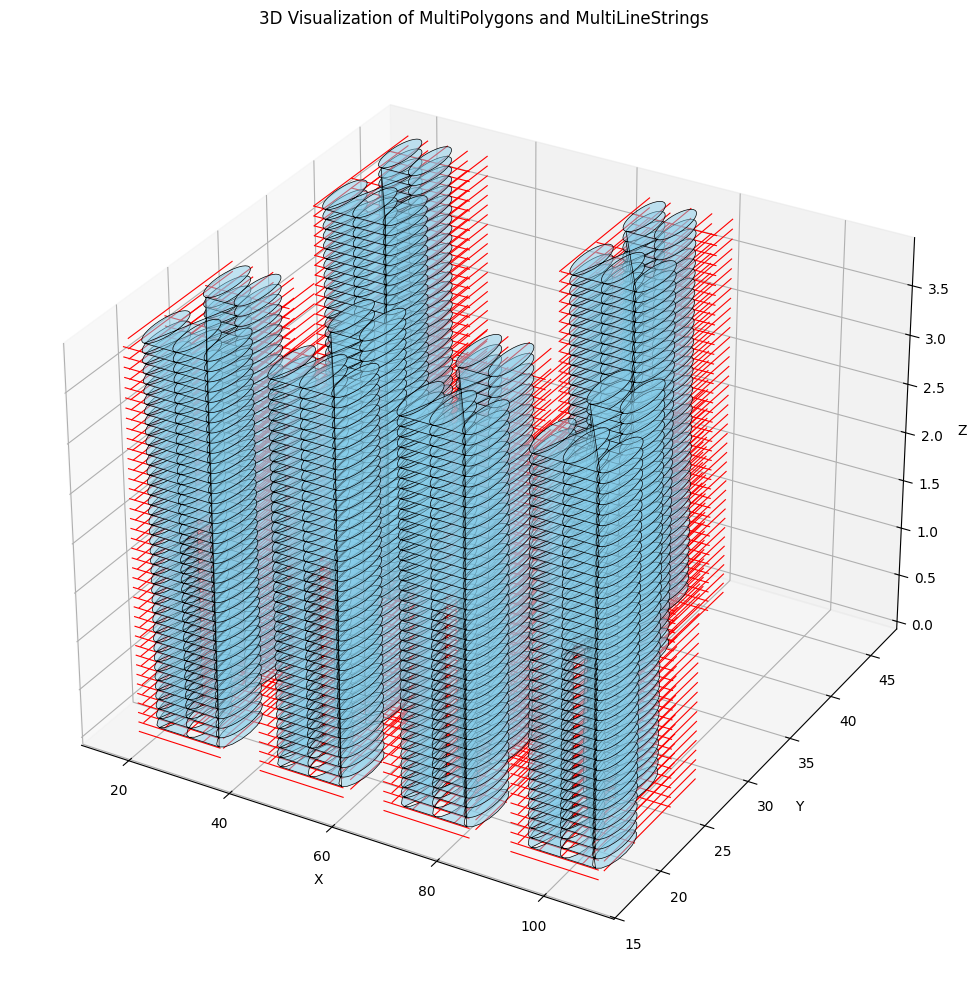

In [24]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from shapely.geometry import LineString, MultiPolygon, MultiLineString

def plot_3d_polygons_and_lines(polygons, linestrings):
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    for multi_poly in polygons:
        for poly in multi_poly.geoms:
            if poly.is_empty:
                continue
            x, y, z = [], [], []
            for coord in poly.exterior.coords:
                x.append(coord[0])
                y.append(coord[1])
                z.append(coord[2])
            verts = [list(zip(x, y, z))]
            ax.add_collection3d(Poly3DCollection(verts, facecolors='skyblue', edgecolors='black', linewidths=0.5, alpha=0.5))
    for multi_line in linestrings:
        for line in multi_line.geoms:
            if line.is_empty:
                continue
            xs, ys, zs = zip(*list(line.coords))
            ax.plot(xs, ys, zs, color='red', linewidth=0.8)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('3D Visualization of MultiPolygons and MultiLineStrings')
    plt.tight_layout()
    plt.show()

plot_3d_polygons_and_lines(polygon, lineString)

## Intersecting Points

In [25]:
from shapely.geometry import Polygon, MultiPolygon, LineString, MultiLineString, GeometryCollection
from shapely.geometry import mapping, shape
from shapely.errors import TopologicalError, GEOSException

def to_2d(geom):
    geojson = mapping(geom)
    def strip_z(coords):
        return [(x, y) for x, y, *_ in coords]
    if geojson['type'] == 'MultiPolygon':
        geojson['coordinates'] = [[strip_z(ring) for ring in poly] for poly in geojson['coordinates']]
    elif geojson['type'] == 'MultiLineString':
        geojson['coordinates'] = [strip_z(line) for line in geojson['coordinates']]
    return shape(geojson)

def get_intersections(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d,no_of_d_row, d_gap, p_value):
    geom,linestring,polygon=create_square_grid(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d,no_of_d_row, d_gap, p_value)
    intersections = [] 
    for i in range(len(polygon)):
        try:
            poly_2d = to_2d(polygon[i])
            line_2d = to_2d(linestring[i])
            if not poly_2d.is_valid:
                poly_2d = poly_2d.buffer(0)
            if not line_2d.is_valid:
                line_2d = line_2d.buffer(0)
            result = poly_2d.intersection(line_2d)
            intersections.append(result)
        except (TopologicalError, GEOSException) as e:
            print(f"Error at layer {i}: {e}")
            intersections.append(GeometryCollection())
    return intersections

intersection_points=get_intersections(20,20,0,2,4,0.1,5,3,10,3,2,2,2,10,4)

In [26]:
def intersection_coords(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d,no_of_d_row, d_gap, p_value):
    intersect_points=get_intersections(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d,no_of_d_row, d_gap, p_value)
    parts = [intersect_points[i:i + 40] for i in range(0, int(len(intersect_points)), int(height/layer_height))]
    each_doc=[]
    for doc in parts:
        doc_list=[]
        for j in doc:
            lines = [geom for geom in j.geoms if isinstance(geom,LineString)]
            doc_list.append(lines)
        new_parts=[]
        for i,line in enumerate(doc_list):
            z=round(layer_height*i,3)
            for j in line:
                new_parts+=[(round(x,2),round(y,2),z)for x,y in j.coords if (x,y,z) not in new_parts]
        each_doc.append(new_parts)
    return each_doc

intersection_points=intersection_coords(20,20,0,2,4,0.1,5,3,10,3,2,2,2,10,4)
print(intersection_points)

[[(21.0, 18.9, 0.0), (21.0, 21.0, 0.0), (21.0, 21.81, 0.0), (21.0, 23.4, 0.0), (21.0, 23.9, 0.0), (21.0, 24.19, 0.0), (21.0, 25.0, 0.0), (21.0, 27.81, 0.0), (25.0, 21.4, 0.0), (25.0, 21.81, 0.0), (25.0, 22.9, 0.0), (25.0, 23.9, 0.0), (25.0, 24.19, 0.0), (25.0, 25.0, 0.0), (25.0, 27.81, 0.0), (33.0, 18.19, 0.0), (33.0, 21.0, 0.0), (33.0, 21.81, 0.0), (18.19, 21.0, 0.0), (21.81, 21.0, 0.0), (25.8, 21.0, 0.0), (27.81, 21.0, 0.0), (30.19, 21.0, 0.0), (33.81, 21.0, 0.0), (18.19, 25.0, 0.0), (21.81, 25.0, 0.0), (24.19, 25.0, 0.0), (27.81, 25.0, 0.0), (21.0, 18.9, 0.1), (21.0, 21.0, 0.1), (21.0, 21.84, 0.1), (21.0, 23.4, 0.1), (21.0, 23.9, 0.1), (21.0, 24.16, 0.1), (21.0, 25.0, 0.1), (21.0, 27.84, 0.1), (25.0, 21.4, 0.1), (25.0, 21.84, 0.1), (25.0, 22.9, 0.1), (25.0, 23.9, 0.1), (25.0, 24.16, 0.1), (25.0, 25.0, 0.1), (25.0, 27.84, 0.1), (33.0, 18.16, 0.1), (33.0, 21.0, 0.1), (33.0, 21.84, 0.1), (18.16, 21.0, 0.1), (21.84, 21.0, 0.1), (25.8, 21.0, 0.1), (27.84, 21.0, 0.1), (30.16, 21.0, 0.1), 

## saving the Coordinates in notepad

In [27]:
def notepad(start_x, start_y, start_z, radius, height, layer_height, no_circle, no_circle_row, gap, no_of_e, no_of_e_row, no_of_d, no_of_d_row, d_gap, p_value):
    intersection_points = intersection_coords(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap, p_value)
    collection_of_e=combining_individual_e_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap)

    with open("notepad_output.txt", "w") as file:
        group_size = no_of_e
        num_groups = len(intersection_points) // group_size
        for d in range(num_groups):
            file.write(f"d-{d + 1}\n")
            f, g = 0, 0
            for e in range(group_size):
                idx = d * group_size + e
                file.write(f" f{f + 1} \n")
                coords=collection_of_e[idx]
                coord_lines = [f"'x'={x},'y'={y},'z'={z}" for x,y,z in coords]
                f=f+1
                for line in coord_lines:
                    file.write(line + "\n")
                file.write(f" g{g + 1} \n")
                intersect = intersection_points[idx]
                intersect_lines = [f"'x'={x},'y'={y},'z'={z}" for x,y,z in intersect]
                g=g+1
                for line in intersect_lines:
                    file.write(line + "\n")

notepad(20,20,0,2,4,0.1,5,3,10,3,2,2,2,10,4)

### Time Performance

In [ ]:
def dict_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap):
    all_coords=combining_individual_e_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap)
    group_size = no_of_e
    num_groups = len(all_coords) // group_size
    coord_dict={}
    for d in range(1,num_groups+1):
        for e in range(1,group_size+1):
            idx = (d-1) * group_size + (e-1)
            coord_dict[f"D{d}E{e}"]=all_coords[idx]
    return coord_dict

def list_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap):
    all_coords=combining_individual_e_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap)
    return all_coords

def tuple_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap):
    all_coords=combining_individual_e_collection(start_x, start_y, start_z, radius, height, layer_height,no_circle, no_circle_row, gap, no_of_e, no_of_e_row,no_of_d, no_of_d_row, d_gap)
    return tuple(all_coords)

In [17]:
import time
tuple_timing_list=[]
start_time_100=time.time()
tuple_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 5, 2, 5, 2, 10)
end_time_100=time.time()
tuple_timing_list.append(end_time_100-start_time_100)

start_time_100=time.time()
tuple_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 10, 2, 10, 2, 10)
end_time_100=time.time()
tuple_timing_list.append(end_time_100-start_time_100)

start_time_100=time.time()
tuple_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 20, 2, 20, 2, 10)
end_time_100=time.time()
tuple_timing_list.append(end_time_100-start_time_100)

dict_timing_list=[]

start_time_100=time.time()
dict_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 5, 2, 5, 2, 10)
end_time_100=time.time()
dict_timing_list.append(end_time_100-start_time_100)

start_time_100=time.time()
dict_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 10, 2, 10, 2, 10)
end_time_100=time.time()
dict_timing_list.append(end_time_100-start_time_100)

start_time_100=time.time()
dict_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 20, 2, 20, 2, 10)
end_time_100=time.time()
dict_timing_list.append(end_time_100-start_time_100)

list_timing_list=[]

start_time_100=time.time()
list_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 5, 2, 5, 2, 10)
end_time_100=time.time()
list_timing_list.append(end_time_100-start_time_100)

start_time_100=time.time()
list_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 10, 2, 10, 2, 10)
end_time_100=time.time()
list_timing_list.append(end_time_100-start_time_100)

start_time_100=time.time()
list_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 20, 2, 20, 2, 10)
end_time_100=time.time()
list_timing_list.append(end_time_100-start_time_100)


In [21]:
tuple_time=["tuple_5","tuple_10","tuple_20"]
dict_time=["dict_5","dict_10","dict_20"]
list_time=["list_5","list_10","list_20"]

Text(0, 0.5, 'tuple_timing_list')

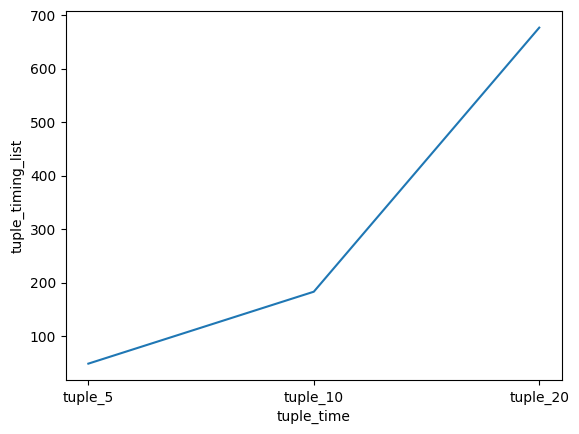

In [22]:
import matplotlib.pyplot as plt
plt.plot(tuple_time,tuple_timing_list)
plt.xlabel("tuple_time")
plt.ylabel("tuple_timing_list")

Text(0, 0.5, 'dict_timing_list')

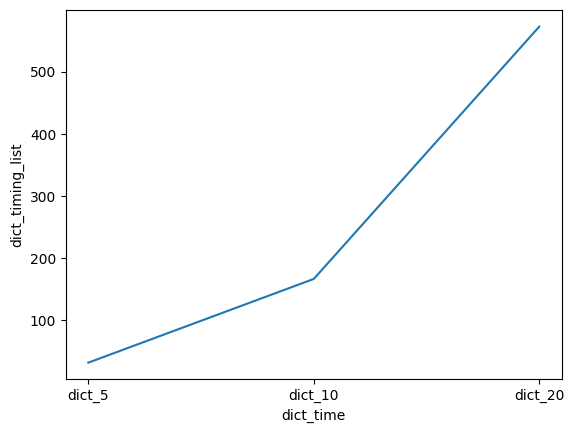

In [23]:
plt.plot(dict_time,dict_timing_list)
plt.xlabel("dict_time")
plt.ylabel("dict_timing_list")

Text(0, 0.5, 'list_timing_list')

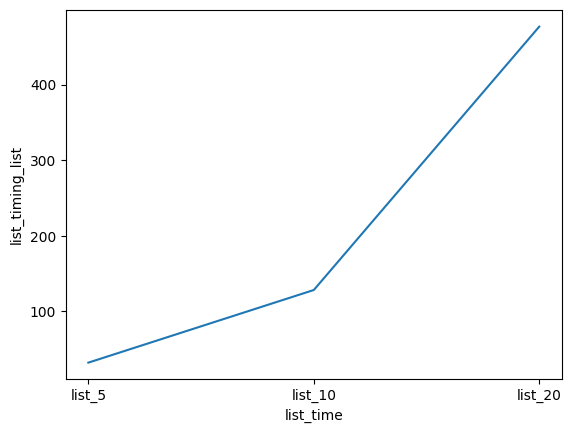

In [24]:
plt.plot(list_time,list_timing_list)
plt.xlabel("list_time")
plt.ylabel("list_timing_list")

## Memory Performance

In [25]:
import tracemalloc

tuple_memory_list=[]
list_memory_list=[]
dict_memory_list=[]

tracemalloc.start()
tuple_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 5, 2, 5, 2, 10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
tuple_memory_list.append(peak)

tracemalloc.start()
tuple_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 10, 2, 10, 2, 10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
tuple_memory_list.append(peak)

tracemalloc.start()
tuple_collection(20,20,0,2,4,0.1,5,3,5,20,2,20,2,10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
tuple_memory_list.append(peak)

tracemalloc.start()
list_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 5, 2, 5, 2, 10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
list_memory_list.append(peak)

tracemalloc.start()
list_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 10, 2, 10, 2, 10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
list_memory_list.append(peak)

tracemalloc.start()
list_collection(20,20,0,2,4,0.1,5,3,5,20,2,20,2,10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
list_memory_list.append(peak)

tracemalloc.start()
dict_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 5, 2, 5, 2, 10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
dict_memory_list.append(peak)

tracemalloc.start()
dict_collection(20, 20, 0, 2, 4, 0.1, 5, 3, 5, 10, 2, 10, 2, 10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
dict_memory_list.append(peak)

tracemalloc.start()
dict_collection(20,20,0,2,4,0.1,5,3,5,20,2,20,2,10)
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
dict_memory_list.append(peak)

Text(0, 0.5, 'tuple_timing_list')

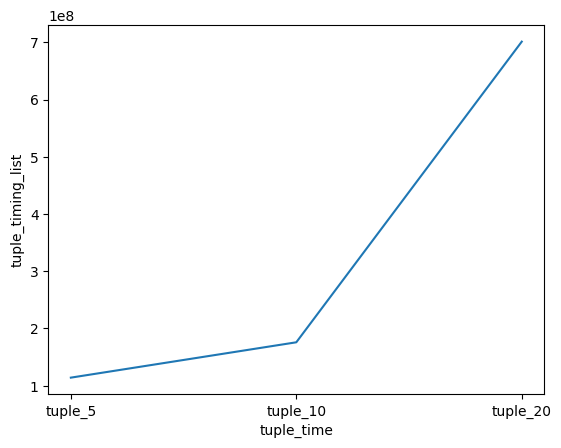

In [26]:
plt.plot(tuple_time,tuple_memory_list)
plt.xlabel("tuple_time")
plt.ylabel("tuple_timing_list")

Text(0, 0.5, 'list_timing_list')

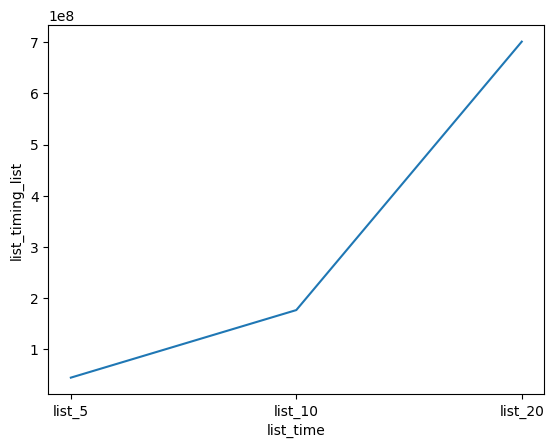

In [27]:
plt.plot(list_time,list_memory_list)
plt.xlabel("list_time")
plt.ylabel("list_timing_list")

Text(0, 0.5, 'list_timing_list')

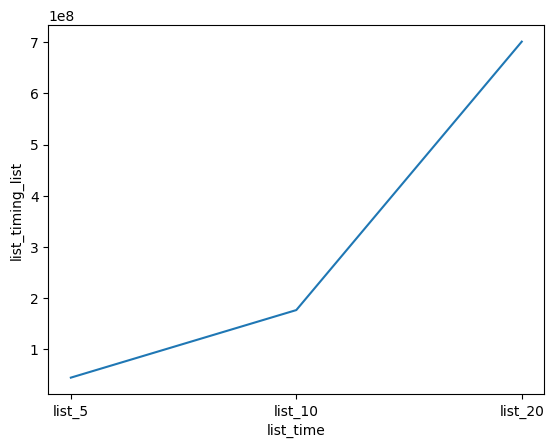

In [28]:
plt.plot(list_time,list_memory_list)
plt.xlabel("list_time")
plt.ylabel("list_timing_list")